### Linear Regression - Feature columns: Date + Zone || Prediction: Pickup count by Zone || Categorized Pickup  Labels

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# FIX ME: Root dir as argument
root_dir = "../../../data/picklerCheckpoints/"
is_compressed = True;

In [5]:
!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install imblearn
import nbimporter
import Preprocessing.SpatialMapping as sm
import Preprocessing.Discretization as dis
import time
import math
import seaborn as sns
plt.rcParams.update({'font.size': 22})

You should consider upgrading via the 'D:\python\python.exe -m pip install --upgrade pip' command.


In [6]:
data = sm.run(['apr', 'may', 'jun', 'jul', 'aug'])

Data for the month :apr Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :may Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :jun Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file

In [7]:
df = data.copy()
columns = ['datetime', 'zone']

In [8]:
df2 = df[columns]
df2g = dis.encode(df2, ['zone'])
df2g = df2.groupby(columns).size().reset_index(name='counts')
df2g['datetime'] = pd.to_datetime(df2g['datetime'], format='%m-%d-%Y:%H').apply(lambda x: time.mktime(x.timetuple()))

D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},


Result Saved in ../data/encodedMappings/zone.p


In [9]:
from sklearn.preprocessing import MinMaxScaler
counts = df2g['counts'].copy()
datetime = df2g['datetime'].copy()

In [10]:
df2g.drop(['counts'], axis=1)[3000:3600]

,datetime,zone
3000,1.396399e+09,146
3001,1.396399e+09,152
3002,1.396399e+09,155
3003,1.396399e+09,156
3004,1.396399e+09,157
...,...,...
3595,1.396417e+09,91
3596,1.396417e+09,93
3597,1.396417e+09,96
3598,1.396417e+09,100


In [11]:
bins = [0, 10, 50, np.inf]
names = ['low', 'med', 'high']

df2g['label'] = pd.cut(df2g['counts'], bins, labels=names)

In [12]:
df2g = dis.encode(df2g, ['label'])

Result Saved in ../data/encodedMappings/label.p


In [13]:
class0, class1, class2 = df2g['label'].value_counts()

In [14]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=101)

In [15]:
x_ros, y_ros = ros.fit_resample(df2g[columns], df2g['label'])
df3 = x_ros
df3['label'] = y_ros

In [16]:
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df3) 
df3.loc[:,:] = scaled_values
df3['counts'] = counts
df3['datetime'] = datetime

In [17]:
x_ros

,datetime,zone,label,counts
0,1.396291e+09,0.155642,0.0,3
1,1.396291e+09,0.525292,0.0,1
2,1.396291e+09,0.894942,0.0,2
3,1.396291e+09,1.000000,0.0,1
4,1.396291e+09,0.155642,0.0,1
...,...,...,...,...
97003,1.399307e+09,0.536965,1.0,1
97004,1.399307e+09,0.883268,1.0,41
97005,1.399307e+09,0.533074,1.0,1
97006,1.399307e+09,0.459144,1.0,2


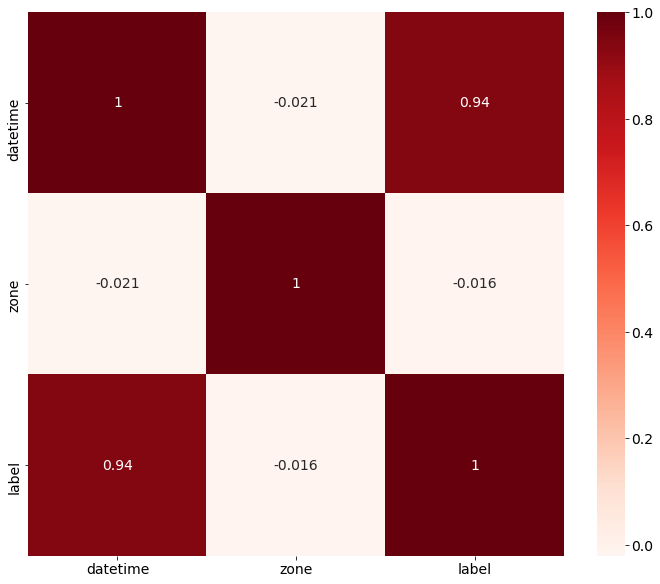

In [18]:
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 14})
corrCols = columns.copy()
corrCols.append('label')
cor = df3[corrCols].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('LinearRegression/LR-2-Correlation.png')
plt.show()

In [19]:
#Correlation with output variable
cor_target = abs(cor["label"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

datetime    0.943636
label       1.000000
Name: label, dtype: float64

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split( df3[columns], df3['label'], test_size=0.33, random_state=100)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [23]:
model = LinearRegression()
startTr = int(round(time.time() * 1000))
trained = model.fit(X_train, y_train)
endTr = int(round(time.time() * 1000))

In [24]:
startTe = int(round(time.time() * 1000))
x_predict = model.predict(X_test)
endTe = int(round(time.time() * 1000))

In [25]:
testDf = pd.DataFrame(X_test, columns=columns)
testDf['label'] = y_test
testDf.loc[:,:] = scaler.inverse_transform(testDf)
predictedDf = pd.DataFrame(X_test, columns=columns)
predictedDf['label'] = x_predict
predictedDf.loc[:,:] = scaler.inverse_transform(predictedDf)
predictedDf['label'] = predictedDf['label'].astype(int)

In [26]:
y_test = testDf['label']
x_predict = predictedDf['label']

In [27]:
from sklearn import metrics

In [28]:
print(metrics.mean_absolute_error(y_test, x_predict))
print(metrics.mean_squared_error(y_test, x_predict))
print(metrics.r2_score(y_test, x_predict))

0.3743166838471871
0.3743166838471871
0.4361202876188598


In [29]:
from sklearn.metrics import classification_report

In [30]:
report = classification_report(y_test, x_predict)
print(report)

              precision    recall  f1-score   support

         0.0       0.66      1.00      0.80     10636
         1.0       0.45      0.50      0.47     10762
         2.0       1.00      0.38      0.55     10615

    accuracy                           0.63     32013
   macro avg       0.70      0.63      0.61     32013
weighted avg       0.70      0.63      0.61     32013



In [31]:
# report = classification_report(y_testdf['label'],  x_predictdf['label'])
# print(report)

In [32]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=2)

In [34]:
pca.fit(X_train)

PCA(n_components=2)

In [35]:
print(pca.explained_variance_ratio_)

[1.00000000e+00 1.03333957e-13]


In [36]:
print(pca.singular_values_)

[2.24675984e+08 7.22234424e+01]


In [37]:
transformed = pd.DataFrame(pca.fit_transform(X_test))


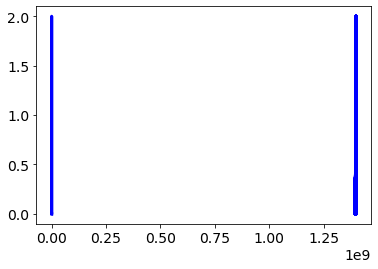

In [38]:
plt.plot(X_test, x_predict, color='blue', linewidth=3)

In [39]:
X_test

,datetime,zone
26945,1.397140e+09,0.607004
81923,1.398875e+09,0.887160
94522,1.399239e+09,0.175097
8713,1.396579e+09,0.249027
20838,1.396949e+09,0.607004
...,...,...
55036,1.398051e+09,0.494163
1711,1.396348e+09,0.871595
70681,1.398530e+09,0.459144
36693,1.397446e+09,0.361868


In [40]:
len(x_predict)

32013

No handles with labels found to put in legend.


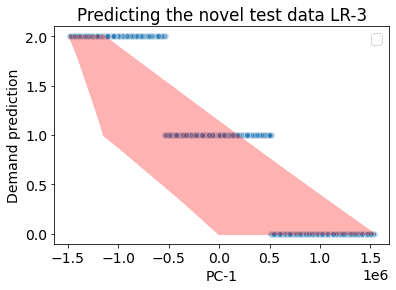

In [41]:
plt.scatter(transformed[0], y_test, edgecolors='w', alpha=0.3)
plt.plot(transformed[0], x_predict, color='r', alpha=0.3)
plt.legend()
plt.xlabel('PC-1')
plt.ylabel('Demand prediction')
plt.title('Predicting the novel test data LR-3')
plt.savefig('LinearRegression/LR-3.png')
plt.show()

In [42]:
print("Training time: = %3d" %(endTr-startTr))

Training time: =   8


In [43]:
print("Testing time: = %3d" %(endTe-startTe))

Testing time: =   4
